In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

C:\Users\AJIT ASHWATH R\AppData\Roaming\Python\Python312\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
#1. Model Definition

In [4]:
class Teacher(nn.Module):
    '''
    ResNet 18
    '''
    def __init__(self, num_classes = 10):
        super(Teacher, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.layer1 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.Conv2d(128, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True)
        )

         
        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride = 2, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, stride = 2, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
            nn.Conv2d(512, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [5]:
class Student(nn.Module):
    """
    CNN
    """
    def __init__(self, num_classes = 10):
        super(Student, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(16, 32, 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(inplace = True),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [6]:
#2. Dataset 

In [7]:
def cidar10(batch_size = 128):
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding = 4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    train_dataset = torchvision.datasets.CIFAR10(
        root = './data', train = True, download = True, transform = train_transform
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root = './data', train = False, download = True, transform = test_transform
    )
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = 2)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers = 2)

    return train_loader, test_loader

In [8]:
#3. Training Functions

In [9]:
def train_standard(model, train_loader, test_loader, epochs = 10, lr = 0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = 1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        train_acc = 100.0 * correct / total
        test_acc = evaluate_model(model, test_loader)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        scheduler.step()
        print(f'Epoch {epoch + 1} / {epochs}: Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')
    return train_accuracies, test_accuracies

In [10]:
def train_with_distillation(student, teacher, train_loader, test_loader, epochs = 10, lr = 0.001, temperature = 4.0, alpha = 0.7):
    teacher.eval()
    criterion_ce = nn.CrossEntropyLoss()
    criterion_kl = nn.KLDivLoss(reduction = 'batchmean')
    optimizer = optim.Adam(student.parameters(), lr = lr, weight_decay = 1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

    train_accuracies = []
    test_accuracies = []
    print(f"Training with distillation: T = {temperature}, Alpha = {alpha}")
    for epoch in range(epochs):
        student.train()
        correct = 0
        total = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            student_output = student(data)
            with torch.no_grad():
                teacher_output = teacher(data)
            hard_loss = criterion_ce(student_output, target)

            student_soft = F.log_softmax(student_output / temperature, dim = 1)
            teacher_soft = F.softmax(teacher_output / temperature, dim = 1)
            soft_loss = criterion_kl(student_soft, teacher_soft) * (temperature ** 2)

            loss = alpha * soft_loss + (1 - alpha) * hard_loss
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(student_output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        train_acc = 100.0 * correct / total
        test_acc = evaluate_model(student, test_loader)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        scheduler.step()
        print(f'Epoch {epoch + 1}/{epochs}: Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')
    return train_accuracies, test_accuracies

In [11]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100.0 * correct / total

In [12]:
#4. Model Analysis

In [13]:
def get_model_size(model):
    param_size = 0
    buffer_size = 0
    
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    size_mb = (param_size + buffer_size) / (1024 * 1024)
    return size_mb

In [14]:
def measure_inference_time(model, test_loader, num_batches = 100):
    model.eval()
    times = []
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            if i >= num_batches:
                break
            data = data.to(device)
            if i < 10:
                _ = model(data)
                continue
            torch.cuda.synchronize() if torch.cuda.is_available() else None
            start = time.time()
            _ = model(data)
            torch.cuda.synchronize() if torch.cuda.is_available() else None
            end = time.time()
            times.append((end - start) * 1000)
    return np.mean(times)

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [16]:
#5. Main

In [17]:
def main():
    train_loader, test_loader = cidar10(batch_size = 128)
    print(f"Dataset loaded: {len(train_loader.dataset)} train, {len(test_loader.dataset)} test")
    
    teacher = Teacher().to(device)
    student_baseline = Student().to(device)
    student_distilled = Student().to(device)
    
    print(f"Teacher parameters: {count_parameters(teacher):,}")
    print(f"Student parameters: {count_parameters(student_baseline):,}")

    print("\nTraining Teacher")
    teacher_train_acc, teacher_test_acc = train_standard(
        teacher, train_loader, test_loader, epochs = 15, lr = 0.001
    )

    print("\nTraining Student")
    student_train_acc, student_test_acc = train_standard(
        student_baseline, train_loader, test_loader, epochs = 15, lr = 0.001
    )
    
    print("\nTraining Student (Distilled)")
    distilled_train_acc, distilled_test_acc = train_with_distillation(
        student_distilled, teacher, train_loader, test_loader, epochs = 15, lr = 0.001, temperature = 4.0, alpha = 0.7
    )

    models = {
        'Teacher': teacher,
        'Student (Baseline)': student_baseline,
        'Student (Distilled)': student_distilled
    }
    
    accuracies = {
        'Teacher': teacher_test_acc[-1],
        'Student (Baseline)': student_test_acc[-1],
        'Student (Distilled)': distilled_test_acc[-1]
    }
    
    results = []
    for name, model in models.items():
        size_mb = get_model_size(model)
        params = count_parameters(model)
        inference_time = measure_inference_time(model, test_loader)
        accuracy = accuracies[name]
        
        results.append({
            'Model': name,
            'Accuracy (%)': accuracy,
            'Size (MB)': size_mb,
            'Parameters': params,
            'Inference Time (ms)': inference_time
        })
    
    results_df = pd.DataFrame(results)
    print("Final Results")
    print(results_df.to_string(index = False, float_format = '%.2f'))
    
    teacher_acc = results_df[results_df['Model'] == 'Teacher']['Accuracy (%)'].iloc[0]
    baseline_acc = results_df[results_df['Model'] == 'Student (Baseline)']['Accuracy (%)'].iloc[0]
    distilled_acc = results_df[results_df['Model'] == 'Student (Distilled)']['Accuracy (%)'].iloc[0]
    
    teacher_size = results_df[results_df['Model'] == 'Teacher']['Size (MB)'].iloc[0]
    student_size = results_df[results_df['Model'] == 'Student (Distilled)']['Size (MB)'].iloc[0]
    
    print("Distillation Benefits")
    print(f"Teacher accuracy: {teacher_acc:.2f}%")
    print(f"Student baseline: {baseline_acc:.2f}%")
    print(f"Student distilled: {distilled_acc:.2f}%")
    print(f"Distillation improvement: {distilled_acc - baseline_acc:.2f} percentage points")
    print(f"Size reduction: {(1 - student_size/teacher_size)*100:.1f}% ({teacher_size:.2f}MB → {student_size:.2f}MB)")
    
    plt.figure(figsize = (15, 10))
    plt.subplot(2, 3, 1)
    models_list = results_df['Model'].tolist()
    accuracies_list = results_df['Accuracy (%)'].tolist()
    colors = ['#e74c3c', '#3498db', '#2ecc71']
    
    bars = plt.bar(models_list, accuracies_list, color = colors)
    plt.title('Model Accuracy Comparison', fontweight = 'bold')
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, max(accuracies_list) * 1.1)
    
    for bar, acc in zip(bars, accuracies_list):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{acc:.1f}%', ha = 'center', va = 'bottom', fontweight = 'bold')
    plt.xticks(rotation = 45)
    
    plt.subplot(2, 3, 2)
    sizes = results_df['Size (MB)'].tolist()
    bars = plt.bar(models_list, sizes, color = colors)
    plt.title('Model Size Comparison', fontweight = 'bold')
    plt.ylabel('Size (MB)')
    
    for bar, size in zip(bars, sizes):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{size:.2f}MB', ha = 'center', va = 'bottom', fontweight = 'bold')
    plt.xticks(rotation = 45)
    
    plt.subplot(2, 3, 3)
    params = results_df['Parameters'].tolist()
    bars = plt.bar(models_list, params, color = colors)
    plt.title('Parameter Count Comparison', fontweight = 'bold')
    plt.ylabel('Parameters')
    
    for bar, param in zip(bars, params):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, f'{param:,}', ha = 'center', va = 'bottom', fontweight = 'bold', fontsize = 9)
    plt.xticks(rotation = 45)

    plt.subplot(2, 3, 4)
    epochs = range(1, len(teacher_test_acc) + 1)
    plt.plot(epochs, teacher_test_acc, 'o-', label = 'Teacher', color = '#e74c3c', linewidth = 2)
    plt.plot(epochs, student_test_acc, 's-', label = 'Student (Baseline)', color = '#3498db', linewidth = 2)
    plt.plot(epochs, distilled_test_acc, '^-', label = 'Student (Distilled)', color = '#2ecc71', linewidth = 2)
    plt.title('Test Accuracy During Training', fontweight = 'bold')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha = 0.3)

    plt.subplot(2, 3, 5)
    times = results_df['Inference Time (ms)'].tolist()
    bars = plt.bar(models_list, times, color = colors)
    plt.title('Inference Time Comparison', fontweight = 'bold')
    plt.ylabel('Time (ms per batch)')
    
    for bar, time_val in zip(bars, times):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, f'{time_val:.1f}ms', ha = 'center', va = 'bottom', fontweight = 'bold')
    plt.xticks(rotation = 45)
    
    plt.subplot(2, 3, 6)
    plt.scatter(sizes, accuracies_list, c = colors, s = 100, alpha = 0.7)
    for i, model in enumerate(models_list):
        plt.annotate(model, (sizes[i], accuracies_list[i]), xytext = (5, 5), textcoords = 'offset points', fontsize = 10)
    plt.title('Accuracy vs Model Size', fontweight = 'bold')
    plt.xlabel('Size (MB)')
    plt.ylabel('Accuracy (%)')
    plt.grid(True, alpha = 0.3)
    
    plt.tight_layout()
    plt.show()
    torch.save(teacher.state_dict(), 'teacher_model.pt')
    torch.save(student_distilled.state_dict(), 'student_distilled.pt')
    print(f"\nModels saved successfully!")
    return results_df

Dataset loaded: 50000 train, 10000 test
Teacher parameters: 4,664,970
Student parameters: 106,826

Training Teacher
Epoch 1 / 15: Train Acc: 46.88%, Test Acc: 57.21%
Epoch 2 / 15: Train Acc: 60.77%, Test Acc: 62.46%
Epoch 3 / 15: Train Acc: 66.58%, Test Acc: 68.21%
Epoch 4 / 15: Train Acc: 70.34%, Test Acc: 71.87%
Epoch 5 / 15: Train Acc: 73.02%, Test Acc: 72.91%
Epoch 6 / 15: Train Acc: 77.48%, Test Acc: 77.19%
Epoch 7 / 15: Train Acc: 78.64%, Test Acc: 78.40%
Epoch 8 / 15: Train Acc: 79.50%, Test Acc: 76.97%
Epoch 9 / 15: Train Acc: 80.39%, Test Acc: 79.79%
Epoch 10 / 15: Train Acc: 81.24%, Test Acc: 79.95%
Epoch 11 / 15: Train Acc: 83.66%, Test Acc: 82.65%
Epoch 12 / 15: Train Acc: 84.44%, Test Acc: 82.29%
Epoch 13 / 15: Train Acc: 85.19%, Test Acc: 82.61%
Epoch 14 / 15: Train Acc: 85.70%, Test Acc: 82.31%
Epoch 15 / 15: Train Acc: 85.88%, Test Acc: 83.13%

Training Student
Epoch 1 / 15: Train Acc: 37.89%, Test Acc: 48.31%
Epoch 2 / 15: Train Acc: 50.54%, Test Acc: 50.51%
Epoch 3 / 

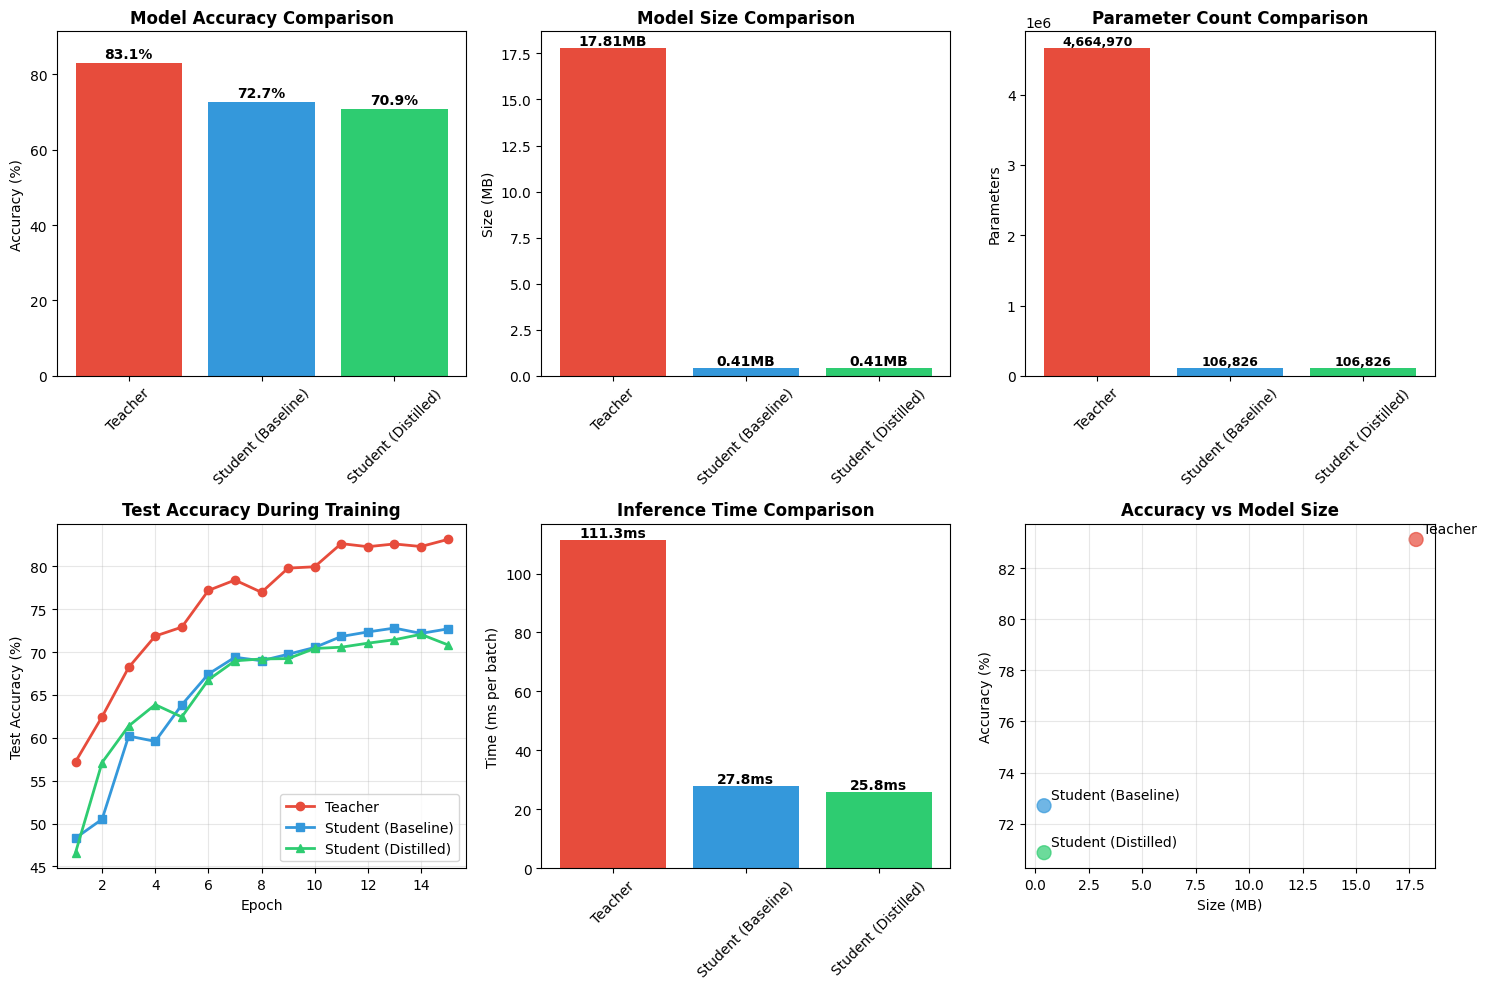


Models saved successfully!


In [18]:
if __name__ == "__main__":
    results = main()